# Image Analysis and Deep Learning - Assignment

---

Group information:
- Jacopo Bulgarelli, jacopo.bulgarelli@gsom.polimi.it
- Gianmarco Fistani, gianmarco.fistani@gsom.polimi.it
- Thomas Colangelo, thomas.colangelo@gsom.polimi.it

Politecnico di Milano, May 2024

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Progetto Deep Learning'
#FOLDERNAME = 'BABD/DL/project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# Change the directory
%cd /content/drive/My\ Drive/$FOLDERNAME
# Check that we are in the correct directory
!pwd
# list all the files
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Progetto Deep Learning
/content/drive/My Drive/Progetto Deep Learning
AssignmentRules.pdf  ExtraNotebooks/      OldReport/   ReportTemplate.docx
data.npz             FinalNotebook.ipynb  Report.gdoc


##1) Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import pandas as pd

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

try:
    import visualkeras
except:
    !pip install visualkeras
    import visualkeras

##2) Load data

In [ ]:
data = np.load("data.npz", allow_pickle=True)
list(data.keys())

['data', 'labels', 'names']

In [ ]:
X = data['data']
X.shape

(15092, 48, 48, 3)

In [ ]:
y = data['labels']
y.shape

(15092, 1)

In [ ]:
labels = data['names']
labels

array({0: 'Basophil', 1: 'Eosinophil', 2: 'Erythroblast', 3: 'Immature Granulocyte', 4: 'Lymphocyte', 5: 'Monocyte', 6: 'Neutrophil', 7: 'Platelet'},
      dtype=object)

##3) Data Analysis

###3.1) EDA
In this section we format the data in order to make them more manageable for the visualizations.

In [ ]:
#data = np.load('data.npz', allow_pickle=True)

In [ ]:
# Extract data, labels, and names
images = data['data']
labels = data['labels']
names = data['names']

# Check the shapes of the arrays
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)

Images shape: (15092, 48, 48, 3)
Labels shape: (15092, 1)


In [ ]:
# Handle the 'names' array appropriately
if names.ndim == 0:  # If names is a 0-dimensional array
    names = names.item()  # Extract the object contained in the array

# Display the first few labels and names
print('First 10 labels:', labels[:10])

First 10 labels: [[3]
 [7]
 [6]
 [5]
 [4]
 [3]
 [5]
 [7]
 [3]
 [3]]


In [ ]:
# If names is a list or an array, print the first 10 names
if isinstance(names, (list, np.ndarray)):
    print('First 10 names:', names[:10])
else:
    print('Names:', names)

Names: {0: 'Basophil', 1: 'Eosinophil', 2: 'Erythroblast', 3: 'Immature Granulocyte', 4: 'Lymphocyte', 5: 'Monocyte', 6: 'Neutrophil', 7: 'Platelet'}


In [ ]:
# Check if labels is 1D, if not, reshape it to be 1D
if labels.ndim != 1:
    labels = labels.reshape(-1)
print('Labels shape after reshaping if needed:', labels.shape)

Labels shape after reshaping if needed: (15092,)


In [ ]:
# Ensure labels are integers
if not np.issubdtype(labels.dtype, np.integer):
    labels = labels.astype(int)

# Inspect the unique values and their counts
unique_labels, counts = np.unique(labels, return_counts=True)
print('Unique labels:', unique_labels)
print('Counts of each label:', counts)

Unique labels: [0 1 2 3 4 5 6 7]
Counts of each label: [1076 2752 1370 2556 1072 1254 2939 2073]


####3.1.1) Distribution of Labels
This chart shows how the labels of the cells are distributed in the dataset

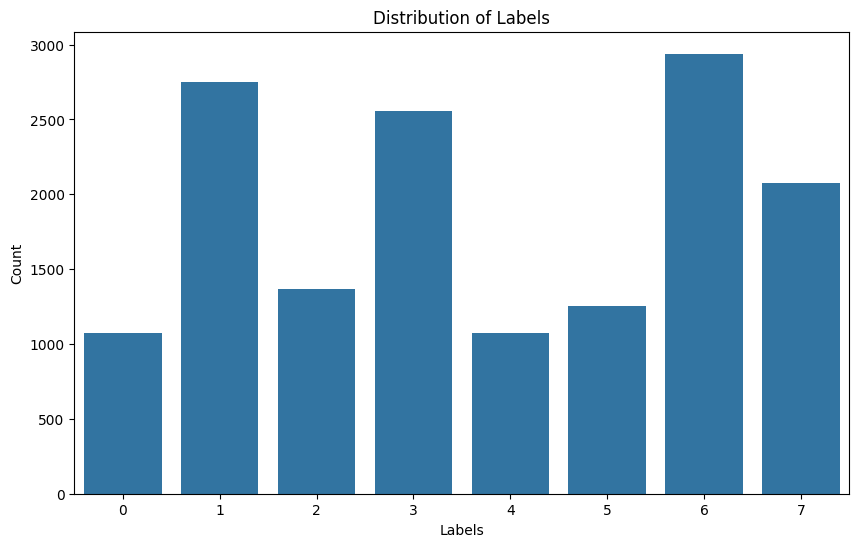

In [ ]:
# Plot the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(x=labels)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

####3.1.2) Scatterplot of cells size

In [ ]:
# Extract features: mean color values for simplicity
mean_red = images[:, :, :, 0].mean(axis=(1, 2))
mean_green = images[:, :, :, 1].mean(axis=(1, 2))
mean_blue = images[:, :, :, 2].mean(axis=(1, 2))

In [ ]:
# Convert images to grayscale
grayscale_images = np.dot(images[..., :3], [0.2989, 0.5870, 0.1140])

# Calculate the mean grayscale value for each image
mean_grayscale_values = grayscale_images.mean(axis=(1, 2))

# Calculate mean black and white values
threshold = 128
mean_black_values = (grayscale_images * (grayscale_images < threshold)).mean(axis=(1, 2))
mean_white_values = (grayscale_images * (grayscale_images >= threshold)).mean(axis=(1, 2))

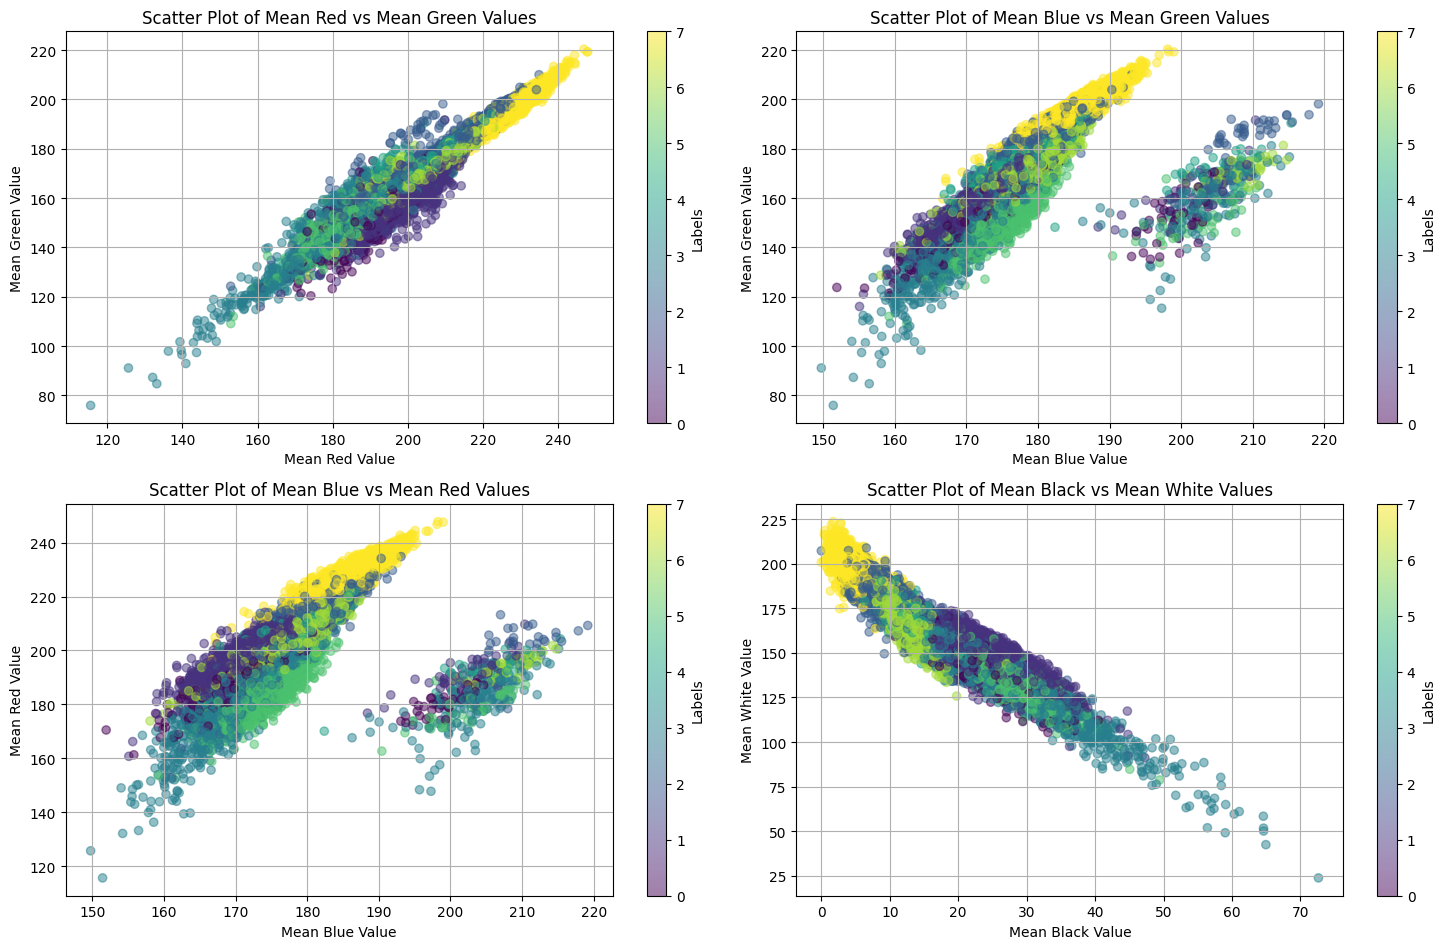

In [ ]:
# Create the scatter plots in subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot 1: Mean Red vs Mean Green
scatter1 = axs[0, 0].scatter(mean_red, mean_green, c=labels, cmap='viridis', alpha=0.5)
axs[0, 0].set_xlabel('Mean Red Value')
axs[0, 0].set_ylabel('Mean Green Value')
axs[0, 0].set_title('Scatter Plot of Mean Red vs Mean Green Values')
fig.colorbar(scatter1, ax=axs[0, 0], label='Labels')
axs[0, 0].grid(True)

# Scatter plot 2: Mean Blue vs Mean Green
scatter2 = axs[0, 1].scatter(mean_blue, mean_green, c=labels, cmap='viridis', alpha=0.5)
axs[0, 1].set_xlabel('Mean Blue Value')
axs[0, 1].set_ylabel('Mean Green Value')
axs[0, 1].set_title('Scatter Plot of Mean Blue vs Mean Green Values')
fig.colorbar(scatter2, ax=axs[0, 1], label='Labels')
axs[0, 1].grid(True)

# Scatter plot 3: Mean Blue vs Mean Red
scatter3 = axs[1, 0].scatter(mean_blue, mean_red, c=labels, cmap='viridis', alpha=0.5)
axs[1, 0].set_xlabel('Mean Blue Value')
axs[1, 0].set_ylabel('Mean Red Value')
axs[1, 0].set_title('Scatter Plot of Mean Blue vs Mean Red Values')
fig.colorbar(scatter3, ax=axs[1, 0], label='Labels')
axs[1, 0].grid(True)

# Scatter plot 4: Mean Black Value vs Mean White Value
scatter4 = axs[1, 1].scatter(mean_black_values, mean_white_values, c=labels, cmap='viridis', alpha=0.5)
axs[1, 1].set_xlabel('Mean Black Value')
axs[1, 1].set_ylabel('Mean White Value')
axs[1, 1].set_title('Scatter Plot of Mean Black vs Mean White Values')
fig.colorbar(scatter4, ax=axs[1, 1], label='Labels')
axs[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()

We can clearly see that label 7 has the images with the lightest colors, suggesting label 7 is the small cells (if the cell is small there are lighter pixels around it since there's more empty space), while label 1 has the darkest colors, meaning they're the bigger and darker cells. The rest of the labels tend to be more in the middle.

####3.1.3) Cells Visualization

In [ ]:
data = np.load("data.npz", allow_pickle=True)
X = data['data']
y = data['labels']
labels = data['names']

In [ ]:
#label mapping
labels = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: 'Erythroblast',
    3: 'Immature Granulocyte',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}

In [ ]:
def display_sample_images(X, y, labels, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        idx = np.random.randint(0, len(X))
        plt.imshow(X[idx].squeeze(), cmap='gray' if X.shape[-1] == 1 else None)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

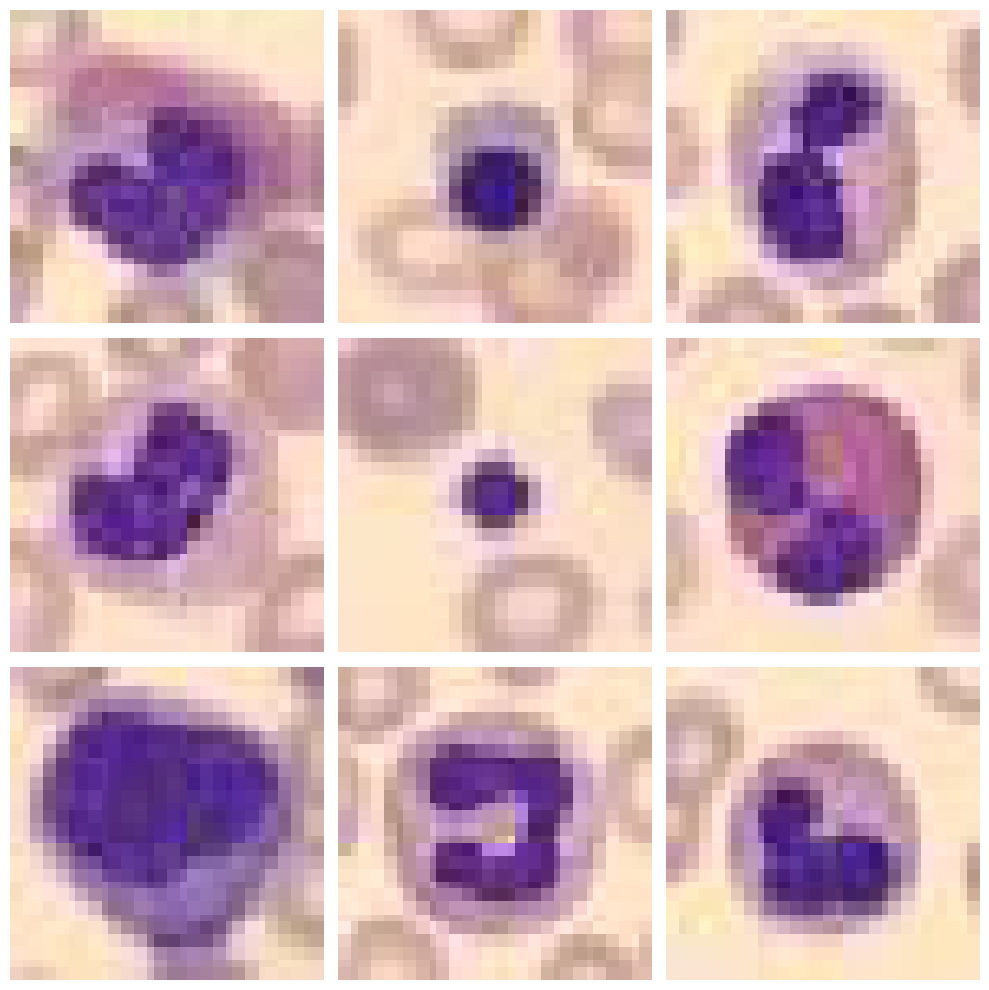

In [ ]:
display_sample_images(X, y, labels)

###3.2) Data Preprocessing
This section focuses on preparing and structuring the data before it is input into our neural network for training, a critical step as data quality and format significantly affect model performance.

In [ ]:
# Check if the images are color (3 channels) or grayscale (1 channel)
if X.ndim == 3:  # Grayscale images
    X = np.expand_dims(X, axis=-1)  # Add channel dimension
elif X.ndim == 4 and X.shape[-1] == 3:  # Color images
    pass  # No need to modify X
else:
    raise ValueError("Unexpected data format: X should be either 3D (grayscale) or 4D (color)")

####3.2.1) Splitting
This approach ensures that the data is split as follows:

- Training: 80% of the data
- Validation: 10% of the data
- Test: 10% of the data

In [ ]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=seed,
    #stratify=y_val
)

In [ ]:
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("")
print("Temp Data Shape:", X_temp.shape)
print("Temp Label Shape:", y_temp.shape)
print("")
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("")
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (12073, 48, 48, 3)
Training Label Shape: (12073, 1)

Temp Data Shape: (3019, 48, 48, 3)
Temp Label Shape: (3019, 1)

Validation Data Shape: (1509, 48, 48, 3)
Validation Label Shape: (1509, 1)

Test Data Shape: (1510, 48, 48, 3)
Test Label Shape: (1510, 1)


####3.2.2) Normalization

Pixel values of images are typically in the range [0, 255], where 0 represents black and 255 represents white (for grayscale images). Normalizing to the range [-1, 1] ensures that all pixel values have a consistent range, which helps in stabilizing and speeding up the training process.

In [ ]:
X_train = (X_train / 255 * 2 - 1).astype('float32')
X_val   = (X_val / 255 * 2 - 1).astype('float32')
X_test  = (X_test / 255 * 2 - 1).astype('float32')

####3.2.3) One-hot encoding

One-hot encoding is a technique used to convert categorical data, such as class labels, into a numerical format that can be used by machine learning algorithms effectively. In our case, there are eight classes: basophils, eosinophils, erythroblasts, immature granulocytes, lymphocytes, neutrophils, monocytes, and platelets.

One-hot encoding works by representing each class label as a binary vector. The vector has a length equal to the number of classes, and each element of the vector corresponds to one of the classes. The element corresponding to the class of the sample is set to 1, while all other elements are set to 0.

For example, if you have three classes (A, B, C), and a sample belongs to class B, the one-hot encoded representation would be:<br>

Class A: [0, 1, 0]<br>
Class B: [1, 0, 0]<br>
Class C: [0, 0, 1]<br><br>
In deep learning model, it's common to represent class labels in this one-hot encoded format because it allows the model to learn the categorical nature of the data more effectively.

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val   = to_categorical(y_val)
y_test  = to_categorical(y_test)

In [ ]:
#Compare categorical label and "default" label
print('Categorical label:', y_train[500])
print('Default label:', np.argmax(y_train[500]))

Categorical label: [0. 0. 0. 0. 0. 0. 0. 1.]
Default label: 7


##4) Models
In this section we implement the two models:<br>
1) The hand-crafted model with feature extraction<br>
2) The deep-model with a custom implementation of LeNet

###4.1) Hand-crafted model

Validation Accuracy: 0.8761
Test Accuracy: 0.9026


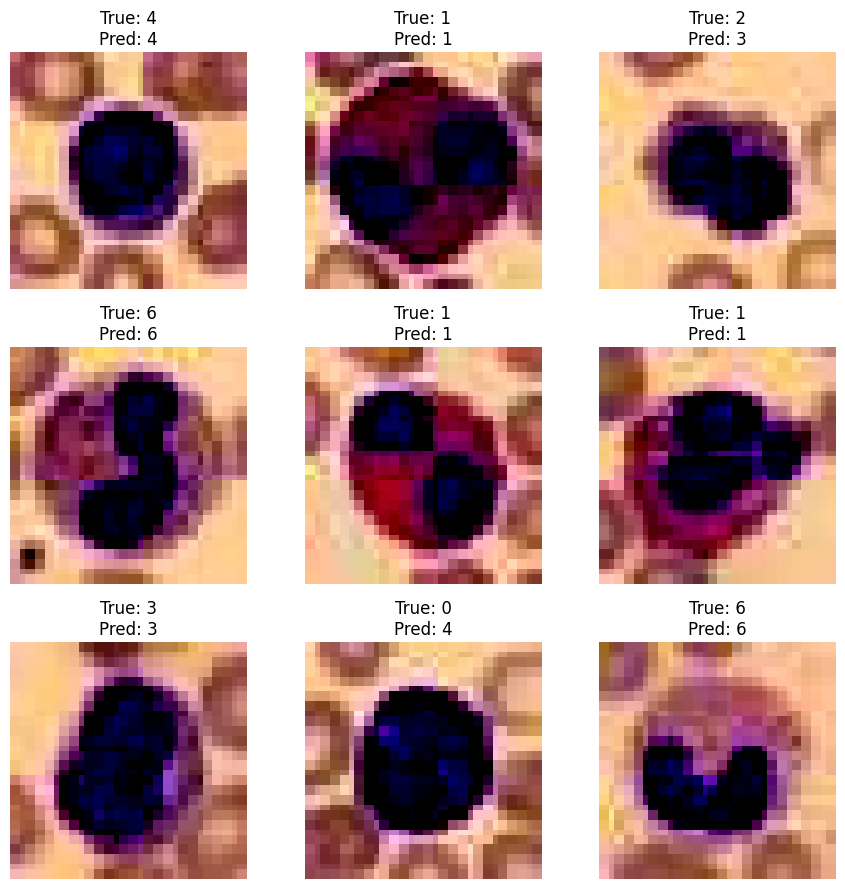

In [ ]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Function to extract features from an image
def extract_features(image):
    # Ensure the image is in the correct format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Compute color histogram
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()

    # Compute Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1.0, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    # Compute average RGB values
    avg_rgb = np.mean(image, axis=(0, 1)).flatten()

    # Compute the perimeter of the cells
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perimeter = sum(cv2.arcLength(c, True) for c in contours)

    # Combine features
    features = np.hstack([hist, lbp_hist, avg_rgb, perimeter])
    return features

# Extract features for the entire dataset
X_train_features = np.array([extract_features(img) for img in X_train])
X_val_features = np.array([extract_features(img) for img in X_val])
X_test_features = np.array([extract_features(img) for img in X_test])

# Encode the labels
label_encoder = LabelEncoder()
y_train_labels = label_encoder.fit_transform(y_train.argmax(axis=1))
y_val_labels = label_encoder.transform(y_val.argmax(axis=1))
y_test_labels = label_encoder.transform(y_test.argmax(axis=1))

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_features, y_train_labels)

# Validate the classifier
val_preds = rf.predict(X_val_features)
val_accuracy = accuracy_score(y_val_labels, val_preds)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Test the classifier
test_preds = rf.predict(X_test_features)
test_accuracy = accuracy_score(y_test_labels, test_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Visualize some predictions
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.ravel()
for i in range(9):
    idx = np.random.randint(0, len(X_test))
    axes[i].imshow(X_test[idx], cmap='gray')
    axes[i].set_title(f"True: {label_encoder.inverse_transform([y_test_labels[idx]])[0]}\nPred: {label_encoder.inverse_transform([test_preds[idx]])[0]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


###4.2) Deep Model

In [ ]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=seed,
    #stratify=y_val
)

#Normalization
X_train = (X_train / 255 * 2 - 1).astype('float32')
X_val   = (X_val / 255 * 2 - 1).astype('float32')
X_test  = (X_test / 255 * 2 - 1).astype('float32')

#One-hot encoding
y_train = to_categorical(y_train)
y_val   = to_categorical(y_val)
y_test  = to_categorical(y_test)

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
batch_size = 128                 # Batch size for training
epochs = 100                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 100
Batch Size: 128
Input Shape: (48, 48, 3)
Output Shape: 8


LeNet implementation

In [ ]:
def build_LeNet(input_shape, output_shape, seed=seed):
  tf.random.set_seed(seed)

  input_layer = tfkl.Input(shape=input_shape, name='Input')

  conv1 = tfkl.Conv2D(
      filters=32, #6
      kernel_size=(3,3), #(5,5)
      padding='same', #valid
      activation='relu', #tanh
      name='conv1'
  )(input_layer)

  pool1 = tfkl.MaxPooling2D(
      pool_size=(2,2),
      name='mp1'
  )(conv1)

  conv2 = tfkl.Conv2D(
      filters=64, #16
      kernel_size=(3,3), #5,5
      padding='same', #valid
      activation='relu', #tanh
      name='conv2'
  )(pool1)

  pool2 = tfkl.MaxPooling2D(
      pool_size =(2,2),
      name='mp2'
  )(conv2)

  flattening_layer=tfkl.Flatten(
      name='flatten'
  )(pool2)

  classifier_layer=tfkl.Dense(
      units=128, #128
      activation='relu', #tanh
      name='dense1'
  )(flattening_layer)

  '''
  classifier_layer = tfkl.Dense(
      units=84,
      activation='tanh',
      name='dense2'
  )(classifier_layer)
  '''

  output_layer = tfkl.Dense(
      units=output_shape,
      activation='softmax',
      name='Output'
  )(classifier_layer)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='LeNet')

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Adam(),
      metrics=['accuracy']
  )

  # Return the model
  return model

In [ ]:
lenet_model = build_LeNet(input_shape, output_shape)

In [ ]:
lenet_model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 32)        896       
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 24, 24, 64)        18496     
                                                                 
 mp2 (MaxPooling2D)          (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense1 (Dense)              (None, 128)               117977

Graphical representation of the network used in this deep model

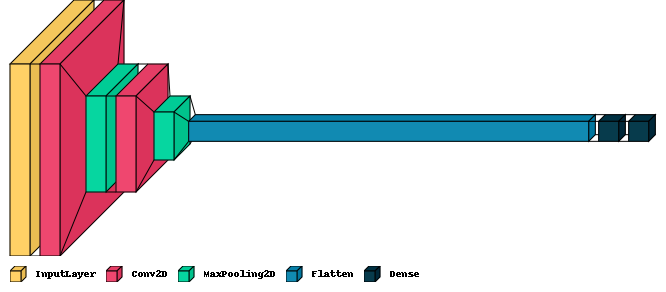

In [ ]:
visualkeras.layered_view(lenet_model, legend=True)

Deep model training

In [ ]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(
  monitor='val_accuracy',
  patience=10,
  mode='max',
  restore_best_weights=True
)

In [ ]:
# Train the lenet_model and save its history
lenet_history = lenet_model.fit(
  x=X_train,
  y=y_train,
  batch_size=batch_size,
  epochs=epochs,
  validation_data=(X_val, y_val),
  callbacks=[early_stopping]
).history

# Save the trained model
lenet_model.save('FinalModel')

Epoch 1/100
95/95 [==============================] - 7s 18ms/step - loss: 0.8513 - accuracy: 0.6927 - val_loss: 0.6299 - val_accuracy: 0.7601
Epoch 2/100
95/95 [==============================] - 1s 10ms/step - loss: 0.4303 - accuracy: 0.8518 - val_loss: 0.4162 - val_accuracy: 0.8595
Epoch 3/100
95/95 [==============================] - 1s 10ms/step - loss: 0.3256 - accuracy: 0.8839 - val_loss: 0.3701 - val_accuracy: 0.8741
Epoch 4/100
95/95 [==============================] - 1s 11ms/step - loss: 0.2800 - accuracy: 0.9009 - val_loss: 0.3031 - val_accuracy: 0.8999
Epoch 5/100
95/95 [==============================] - 1s 11ms/step - loss: 0.2344 - accuracy: 0.9173 - val_loss: 0.3005 - val_accuracy: 0.9079
Epoch 6/100
95/95 [==============================] - 1s 11ms/step - loss: 0.1989 - accuracy: 0.9317 - val_loss: 0.2962 - val_accuracy: 0.9046
Epoch 7/100
95/95 [==============================] - 1s 11ms/step - loss: 0.1787 - accuracy: 0.9358 - val_loss: 0.2773 - val_accuracy: 0.9152
Epoch 

In [ ]:
lenet_model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 32)        896       
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 24, 24, 64)        18496     
                                                                 
 mp2 (MaxPooling2D)          (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense1 (Dense)              (None, 128)               117977

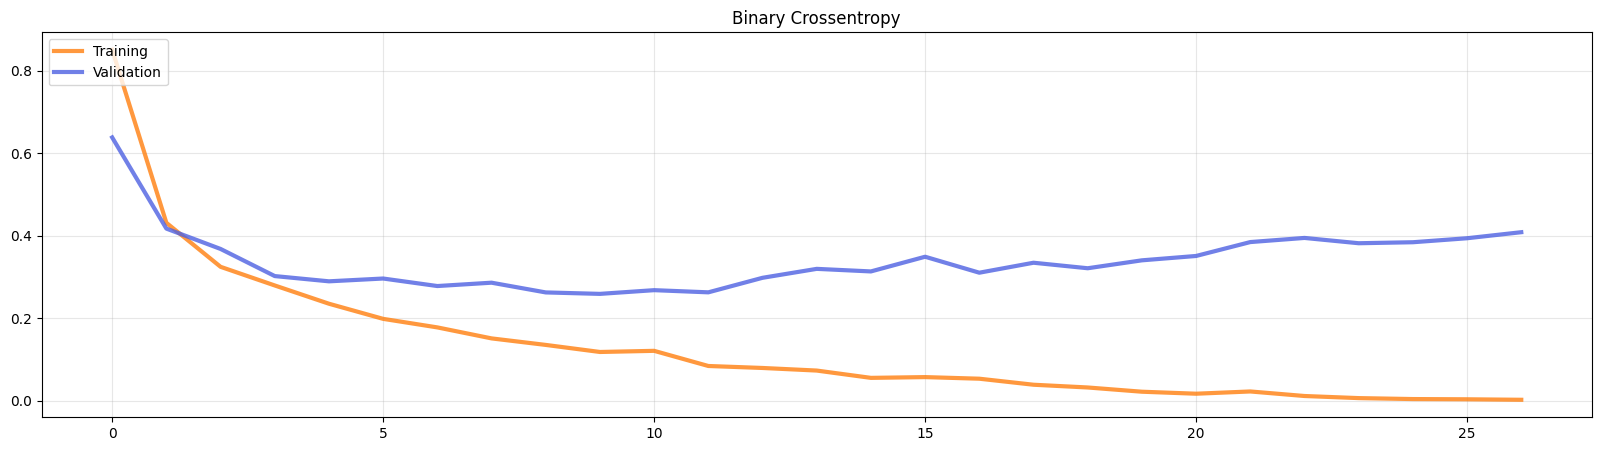

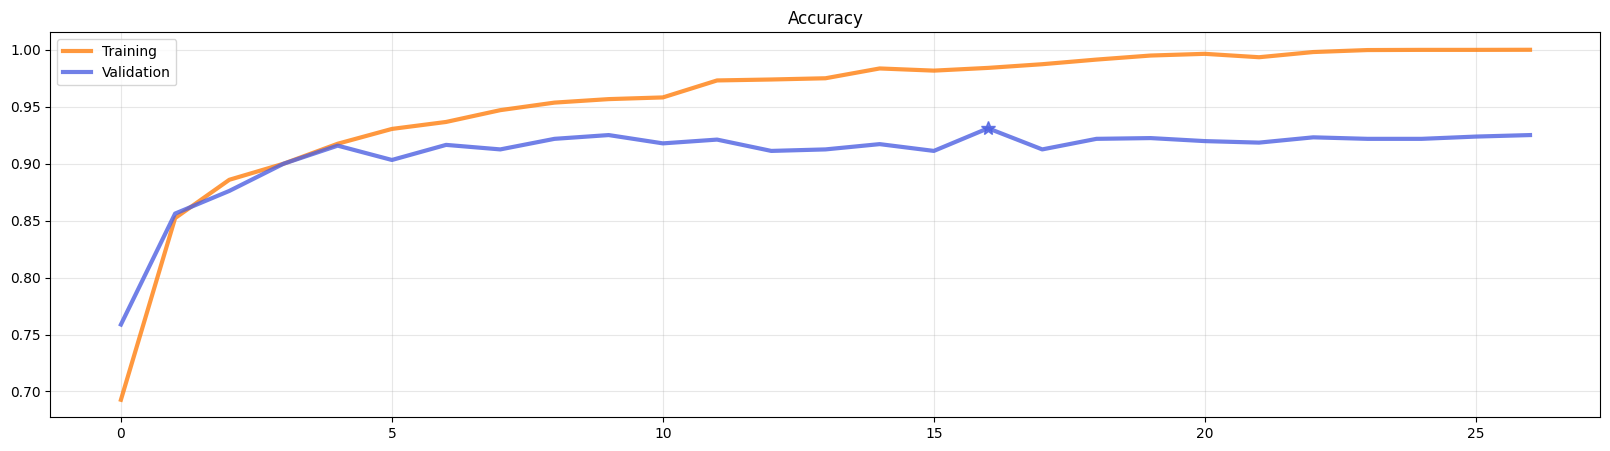

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(lenet_history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(lenet_history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(lenet_history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(lenet_history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(lenet_history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, lenet_history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Delete the model instance to free up memory
del lenet_model

In [ ]:
# Load the saved LeNet model
final_model = tfk.models.load_model('FinalModel')

In [ ]:
# Extract activations from the first convolutional layer for a subset of test images
num_images = 100
first_conv = tfk.Sequential(final_model.layers[:2])
first_activations = first_conv(X_test[0:num_images])

# Extract activations from the second convolutional layer for the same subset of test images
second_conv = tfk.Sequential(final_model.layers[:4])
second_activations = second_conv(X_test[0:num_images])

In [ ]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("first_activations shape:", first_activations.shape)
print("second_activations shape:", second_activations.shape)

X_test shape: (1510, 48, 48, 3)
y_test shape: (1510, 8)
first_activations shape: (100, 48, 48, 32)
second_activations shape: (100, 24, 24, 64)


In [ ]:
# Predict labels for the entire test set
dm_predictions = final_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", dm_predictions.shape)

Predictions Shape: (1510, 8)


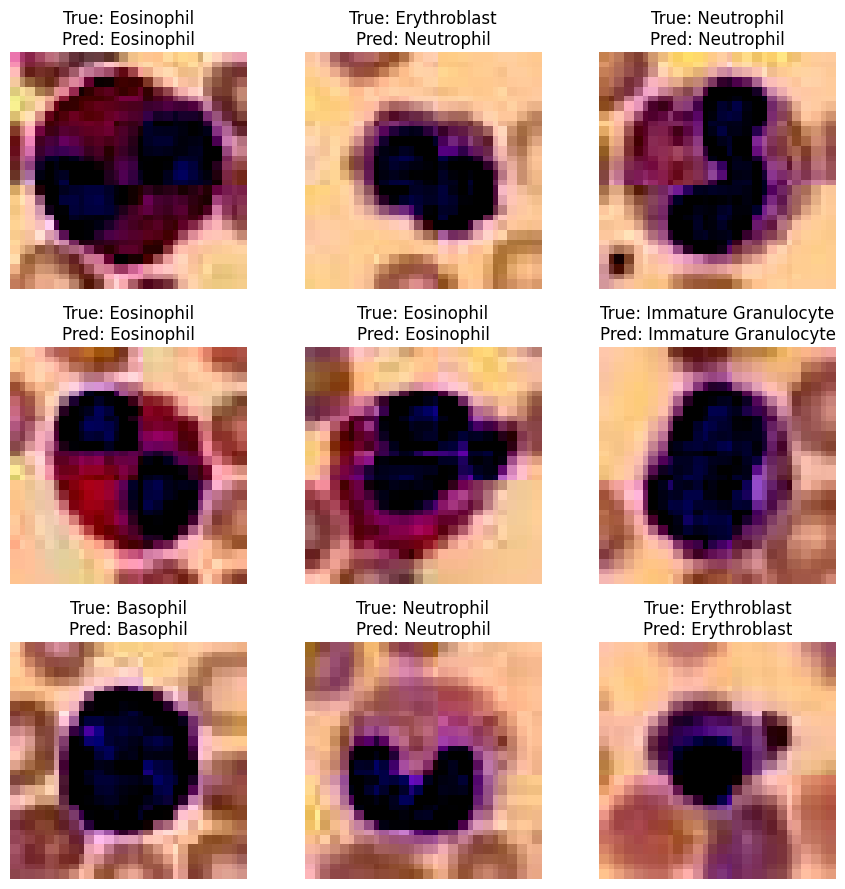

In [ ]:
# Display random images with true and predicted labels
pred_labels = np.argmax(dm_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.ravel()
for i in range(9):
    idx = np.random.randint(0, len(X_test))
    axes[i].imshow(X_test[idx], cmap='gray')
    axes[i].set_title(f"True: {labels[true_labels[idx]]}\nPred: {labels[pred_labels[idx]]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

As in the previous case (Hand-crafted moldes) the labels might be wrong because of the not perfect accurancy

In [ ]:
# Compute classification metrics
accuracy  = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(dm_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(dm_predictions, axis=-1), average='macro')
recall    = recall_score(np.argmax(y_test, axis=-1), np.argmax(dm_predictions, axis=-1), average='macro')
f1        = f1_score(np.argmax(y_test, axis=-1), np.argmax(dm_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy: ', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:   ', recall.round(4))
print('F1:       ', f1.round(4))

Accuracy:  0.9397
Precision: 0.9318
Recall:    0.9365
F1:        0.9336


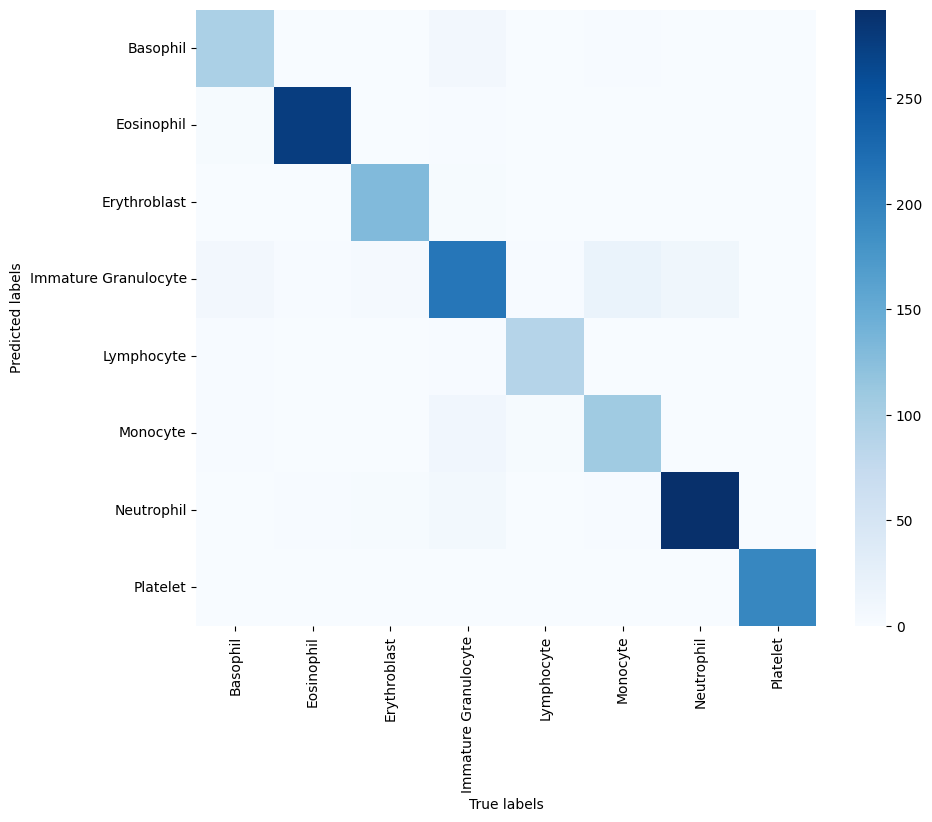

In [ ]:
# Compute the confusion matrix
dm_cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(dm_predictions, axis=-1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(dm_cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

The color intensity in each cell represents the number of observations, with darker shades indicating a higher count. For example, a dark block at the intersection of 'Neutrophil' in both predicted and true labels suggests a high number of correct predictions for Neutrophils. Conversely, lighter shades or white cells indicate fewer or no observations for those category combinations, reflecting fewer misclassifications or correct classifications in lesser-known classes.

##5) Make test inference
This is the function we will use to evaluate your deep model.

In [ ]:
from tensorflow.keras.utils import to_categorical

def test_model(test_data_path, model_path):
    # Load the data
    data = np.load(test_data_path)
    X_test = data['data']
    y_test = data['labels'].astype('int32')

    # The data that will be used to test your model will be in range [0,255] and with type int32
    # If you need, modify the normalization step
    #X_test = (X_test/255.).astype('float32')
    X_test = (X_test / 255 * 2 - 1).astype('float32')
    #y_test = to_categorical(y_test)

    # Load the final model
    final_model = tfk.models.load_model(model_path)

    # Make the test predictions
    predictions = final_model.predict(X_test, verbose=0)
    predictions = np.argmax(predictions, axis=-1).astype('int32')

    # Compute classification metrics
    accuracy = accuracy_score(y_test, predictions)

    # Display the computed metrics
    print('Accuracy:', accuracy.round(4))

In [ ]:
np.savez('test_data.npz',data=X_test, labels=y_test) #NOTE: the function doesn't work with this ds

In [ ]:
test_data_path = 'data.npz'
model_path = 'FinalModel'
test_model(test_data_path, model_path)

Accuracy: 0.9857
